# Recursive showdown—regression

In [1]:
import os

os.environ["TPU_CHIPS_PER_HOST_BOUNDS"] = "1,1,1"
os.environ["TPU_HOST_BOUNDS"] = "1,1,1"
# Different per process:
os.environ["TPU_VISIBLE_DEVICES"] = "1"

In [2]:
import jax
import optax
import flax.linen as nn
import jax.numpy as jnp
import matplotlib.pyplot as plt
from typing import Callable
from functools import partial

In [3]:
from rebayes.utils import datasets
from rebayes import replay_sgd as rsgd
from rebayes.extended_kalman_filter import ekf
from rebayes.low_rank_filter import lofi

In [4]:
from jax.flatten_util import ravel_pytree 

In [5]:
%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2

In [6]:
# train, test = datasets.load_1d_synthetic_dataset(5_000, 500, sort_data=False)
# train, test = datasets.load_rotated_mnist(num_train=5_000, target_digit=2, sort_by_angle=False)
# train, test = datasets.load_uci_wine_regression()
# train, test = datasets.load_uci_naval()
# train, test = datasets.load_uci_kin8nm()
train, test = datasets.load_uci_power()

(X_train, y_train) = train
(X_test, y_test) = test

y_train = y_train.ravel()
y_test = y_test.ravel()

In [7]:
X_train.shape, X_test.shape

((7654, 4), (1914, 4))

In [8]:
key = jax.random.PRNGKey(3141)
key_init, key_train = jax.random.split(key)

## The Model

In [9]:
class MLP(nn.Module):
    n_out: int
    activation: Callable = nn.relu
    
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(50)(x)
        x = self.activation(x)
        x = nn.Dense(50)(x)
        x = self.activation(x)
        # x = nn.Dense(50)(x)
        # x = self.activation(x)
        # x = nn.Dense(10)(x)
        # x = self.activation(x)
        x = nn.Dense(self.n_out)(x)
        return x

In [10]:
def rmae_callback(bel, *args, **kwargs):
    X_test, y_test = kwargs["X_test"], kwargs["y_test"]
    apply_fn = kwargs["apply_fn"]
    
    yhat = apply_fn(bel.mean, X_test).squeeze()
    err = jnp.abs(y_test - yhat.ravel())
    
    res = {
        "test": err.mean()
    }
    return res

## The models

In [11]:
_, dim_in = X_train.shape
# dim_in = 28 ** 2
dim_out = 1
learning_rate = 1e-6

In [12]:
@partial(jax.jit, static_argnames=("applyfn",))
def lossfn_fifo(params, counter, X, y, applyfn):
    yhat = applyfn(params, X).ravel()
    loss = (y - yhat) ** 2
    loss = (loss * counter).sum() / counter.sum()
    return loss

In [13]:
model = MLP(dim_out, activation=nn.elu)
batch_init = jnp.ones((1, dim_in))
params_init = model.init(key_init, batch_init)

In [16]:
%%time
buffer_size = 50
n_inner = 1

state_init = rsgd.FifoTrainState.create(
    apply_fn=model.apply,
    params=params_init,
    tx=optax.adam(learning_rate),
    buffer_size=buffer_size,
    dim_features=dim_in,
    dim_output=dim_out,
)


rebayes = rsgd.FSGD(lossfn_fifo, n_inner=n_inner)

test = {"X_test": X_test, "y_test": y_test, "apply_fn": model.apply}
state, output_rsg = rebayes.scan(X_train, y_train, bel=state_init, callback=rmae_callback, **test)
acc = output_rsg["test"][-1]
acc

CPU times: user 1.33 s, sys: 44.1 ms, total: 1.37 s
Wall time: 1.05 s


  0%|          | 0/7654 [00:00<?, ?it/s]

Array(0.8892825, dtype=float32)

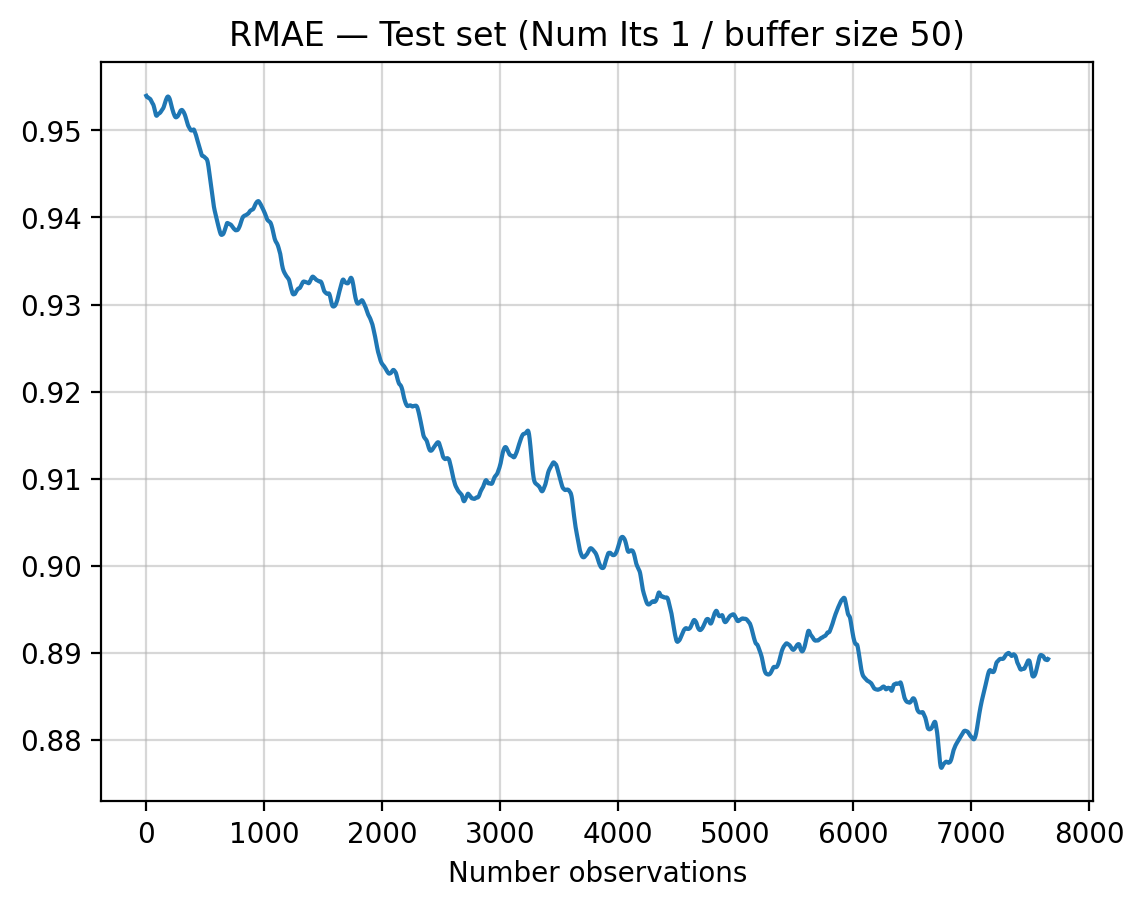

In [17]:
plt.plot(output_rsg["test"])
plt.grid(alpha=0.5)
plt.xlabel("Number observations")
plt.title(f"RMAE — Test set (Num Its {n_inner} / buffer size {buffer_size})");

## ORFit

In [18]:
flat_params, reconstruct_fn = ravel_pytree(params_init)
# Define apply function
def apply(flat_params, x, model, unflatten_fn):
    return model.apply(unflatten_fn(flat_params), x)

apply_fn = partial(apply, model=model, unflatten_fn=reconstruct_fn)

In [19]:
log_init_cov = -1.0#-2.495
dynamics_weights = 1.0#0.95
log_emission_cov = -0.83

orfit_params_linear = lofi.LoFiParams(
    memory_size=50,
    sv_threshold=0.0
)

model_params_linear = lofi.RebayesParams(
    initial_mean=flat_params,
    initial_covariance=jnp.power(10, log_init_cov).item(),
    dynamics_weights=dynamics_weights,
    dynamics_covariance=1e-5,
    emission_mean_function=apply_fn,
    emission_cov_function=lambda w, x: jnp.power(10, log_emission_cov),
)



estimator_orfit = lofi.RebayesLoFi(model_params_linear, orfit_params_linear, method='orfit')
estimator_lofi = lofi.RebayesLoFi(model_params_linear, orfit_params_linear, method='lofi')
estimator_aov_lofi = lofi.RebayesLoFi(model_params_linear, orfit_params_linear, method='aov_lofi')

test = {"X_test": X_test, "y_test": y_test, "apply_fn": apply_fn}
bel, output_orfit = estimator_orfit.scan(X_train, y_train, callback=rmae_callback, **test)
bel, output_lofi = estimator_lofi.scan(X_train, y_train, callback=rmae_callback, **test)
bel, output_aov_lofi = estimator_aov_lofi.scan(X_train, y_train, callback=rmae_callback, **test)

  0%|          | 0/7654 [00:00<?, ?it/s]

  0%|          | 0/7654 [00:00<?, ?it/s]

## fully-decoupled EKF

In [20]:
log_init_cov = -2.495
dynamics_weights = 1.0
log_emission_cov = -0.83

In [21]:
model_params_linear = lofi.RebayesParams(
    initial_mean=flat_params,
    initial_covariance=jnp.power(10, log_init_cov).item() *  jnp.ones_like(flat_params),
    dynamics_weights=dynamics_weights,
    dynamics_covariance=1e-5,
    emission_mean_function=apply_fn,
    emission_cov_function=lambda w, x: jnp.power(10, log_emission_cov),
)


estimator_fdekf = ekf.RebayesEKF(model_params_linear, method="fdekf")

test = {"X_test": X_test, "y_test": y_test, "apply_fn": apply_fn}
bel, output_fdekf = estimator_fdekf.scan(X_train, y_train, callback=rmae_callback, **test)

  0%|          | 0/7654 [00:00<?, ?it/s]

## Full-covariance EKF

## Analysing results

In [22]:
import pandas as pd
import numpy as np

  0%|          | 0/7654 [00:00<?, ?it/s]

In [23]:
data = {
    "rsgd": np.array(output_rsg["test"]),
    "orfit": np.array(output_orfit["test"]),
    "lofi": np.array(output_lofi["test"]),
    "lofi-aov": np.array(output_aov_lofi["test"]),
    "fd-ekf": np.array(output_fdekf["test"])
}

data = pd.DataFrame(data)

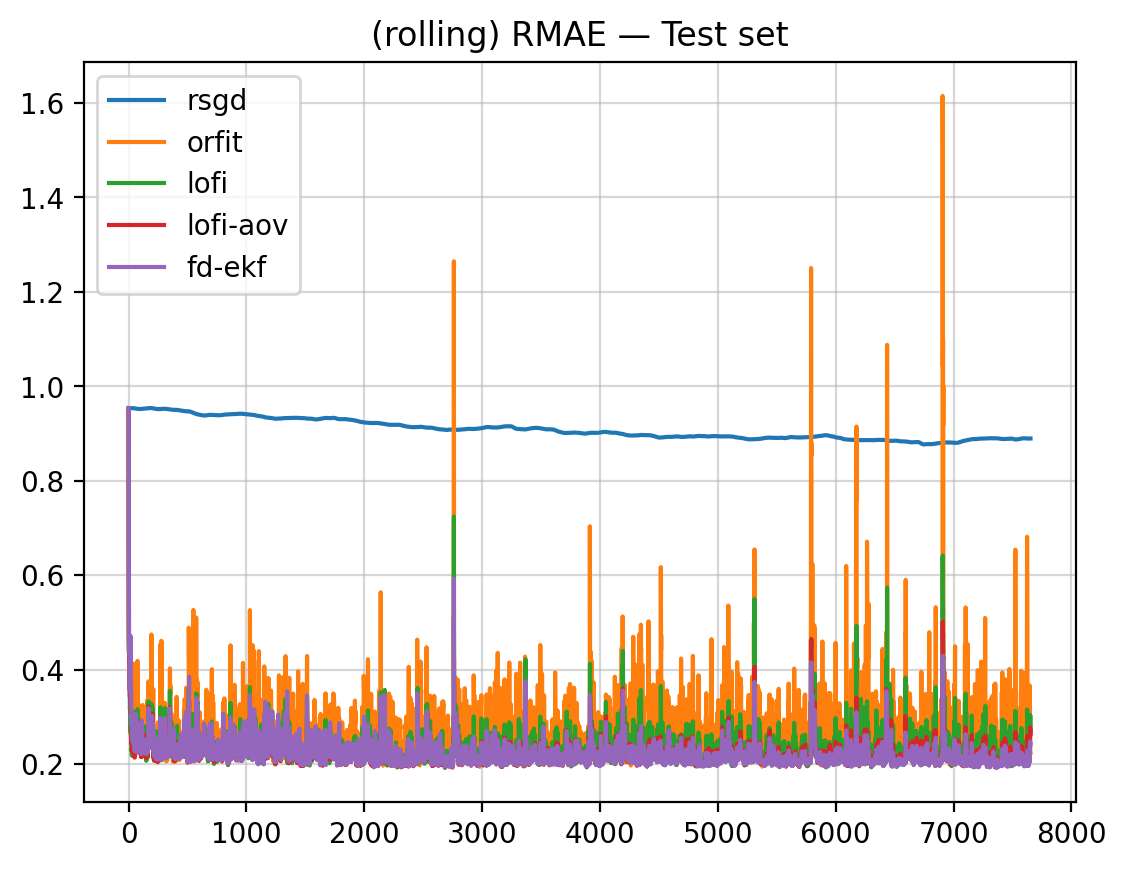

In [24]:
data.plot()
plt.title(f"(rolling) RMAE — Test set");
plt.grid(alpha=0.5)
plt.legend()

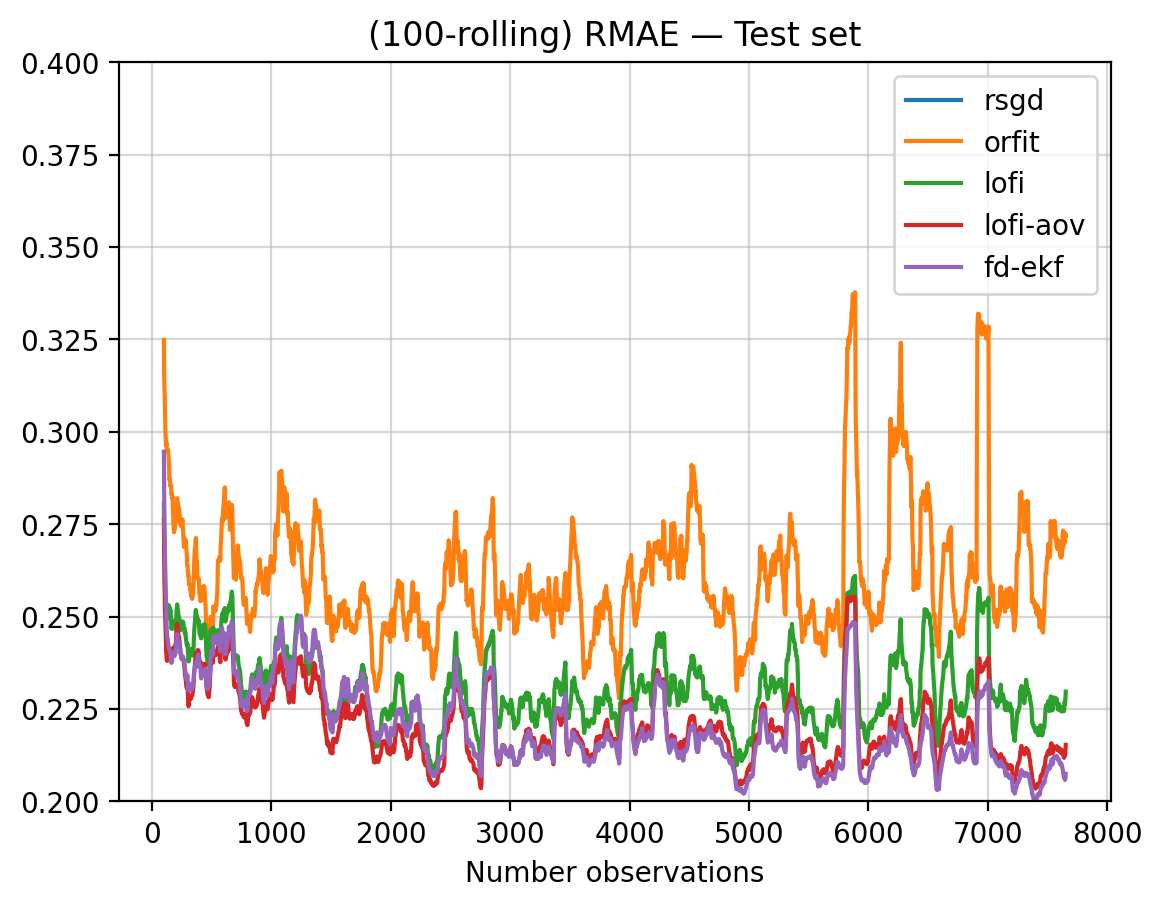

In [30]:
data.drop([], axis=1).rolling(100).mean().plot()
plt.xlabel("Number observations")
plt.title(f"(100-rolling) RMAE — Test set")
plt.ylim(0.2, 0.4)
plt.grid(alpha=0.5)